# Projeto Final Big Data

### Aluno: Tiago Custodio

## Atividade: realizar um ciclo completo do Spark

----------------------------------------------

# Passo 1: Setup do Projeto

In [1]:
# instalar as dependências
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
# configurar as variáveis de ambiente
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

# tornar o pyspark "importável"
import findspark
findspark.init('spark-2.4.4-bin-hadoop2.7')

In [3]:
import pyspark

contexto = pyspark.SparkContext(appName='projeto_final')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [57]:
from pyspark.sql.functions import mean
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import  MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [63]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Passo 2: Recuperação de Dados

### Base de Dados: 

wine_data

### Disponível em:

https://archive.ics.uci.edu/ml/machine-learning-databases/wine/

O objetivo do dataset é classificar qual o tipo de vinho de acordo com suas propriedades

In [6]:
wine_data = spark.read.csv('/content/wine.csv', inferSchema=True, header=True)

# Passo 3: Análise Exploratória

In [7]:
wine_data.show()

+----+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+
|name|alcohol|malic_acid| ash|alcalinity_of_ash|magnesium|total_phenols|flavanoids|nonflavanoid_phenols|proanthocyanins|color_intensity| hue|OD280/OD315_of_diluted_wines|proline|
+----+-------+----------+----+-----------------+---------+-------------+----------+--------------------+---------------+---------------+----+----------------------------+-------+
|   1|  14.23|      1.71|2.43|             15.6|      127|          2.8|      3.06|                0.28|           2.29|           5.64|1.04|                        3.92|   1065|
|   1|   13.2|      1.78|2.14|             11.2|      100|         2.65|      2.76|                0.26|           1.28|           4.38|1.05|                         3.4|   1050|
|   1|  13.16|      2.36|2.67|             18.6|      101|          2.8|      3.24|                 0.3| 

In [8]:
wine_data.summary().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+----------------------------+-----------------+
|summary|              name|           alcohol|        malic_acid|               ash|alcalinity_of_ash|         magnesium|     total_phenols|        flavanoids|nonflavanoid_phenols|   proanthocyanins|  color_intensity|                hue|OD280/OD315_of_diluted_wines|          proline|
+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+----------------------------+-----------------+
|  count|               178|               178|               178|               178|              178|               178|               178| 

In [9]:
wine_data.printSchema()

root
 |-- name: integer (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- malic_acid: double (nullable = true)
 |-- ash: double (nullable = true)
 |-- alcalinity_of_ash: double (nullable = true)
 |-- magnesium: integer (nullable = true)
 |-- total_phenols: double (nullable = true)
 |-- flavanoids: double (nullable = true)
 |-- nonflavanoid_phenols: double (nullable = true)
 |-- proanthocyanins: double (nullable = true)
 |-- color_intensity: double (nullable = true)
 |-- hue: double (nullable = true)
 |-- OD280/OD315_of_diluted_wines: double (nullable = true)
 |-- proline: integer (nullable = true)



In [10]:
wine_data.dtypes

[('name', 'int'),
 ('alcohol', 'double'),
 ('malic_acid', 'double'),
 ('ash', 'double'),
 ('alcalinity_of_ash', 'double'),
 ('magnesium', 'int'),
 ('total_phenols', 'double'),
 ('flavanoids', 'double'),
 ('nonflavanoid_phenols', 'double'),
 ('proanthocyanins', 'double'),
 ('color_intensity', 'double'),
 ('hue', 'double'),
 ('OD280/OD315_of_diluted_wines', 'double'),
 ('proline', 'int')]

In [11]:
wine_data.groupBy('name').count().show()

+----+-----+
|name|count|
+----+-----+
|   1|   59|
|   3|   48|
|   2|   71|
+----+-----+



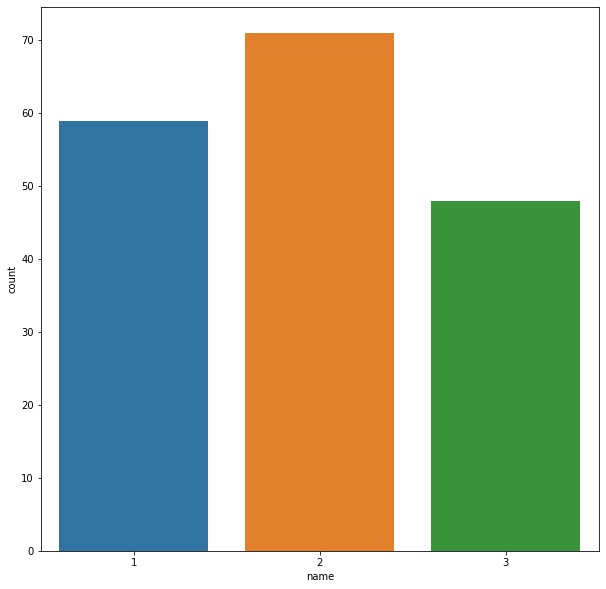

In [64]:
wine_pandas = wine_data.toPandas()
plt.figure(figsize=(10,10))
_ = sns.countplot(x='name',data=wine_pandas)

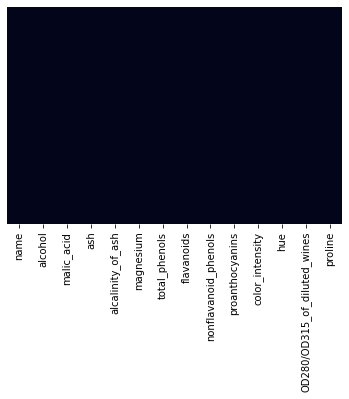

In [65]:
_ = sns.heatmap(wine_pandas.isnull(), yticklabels=False, cbar=False)

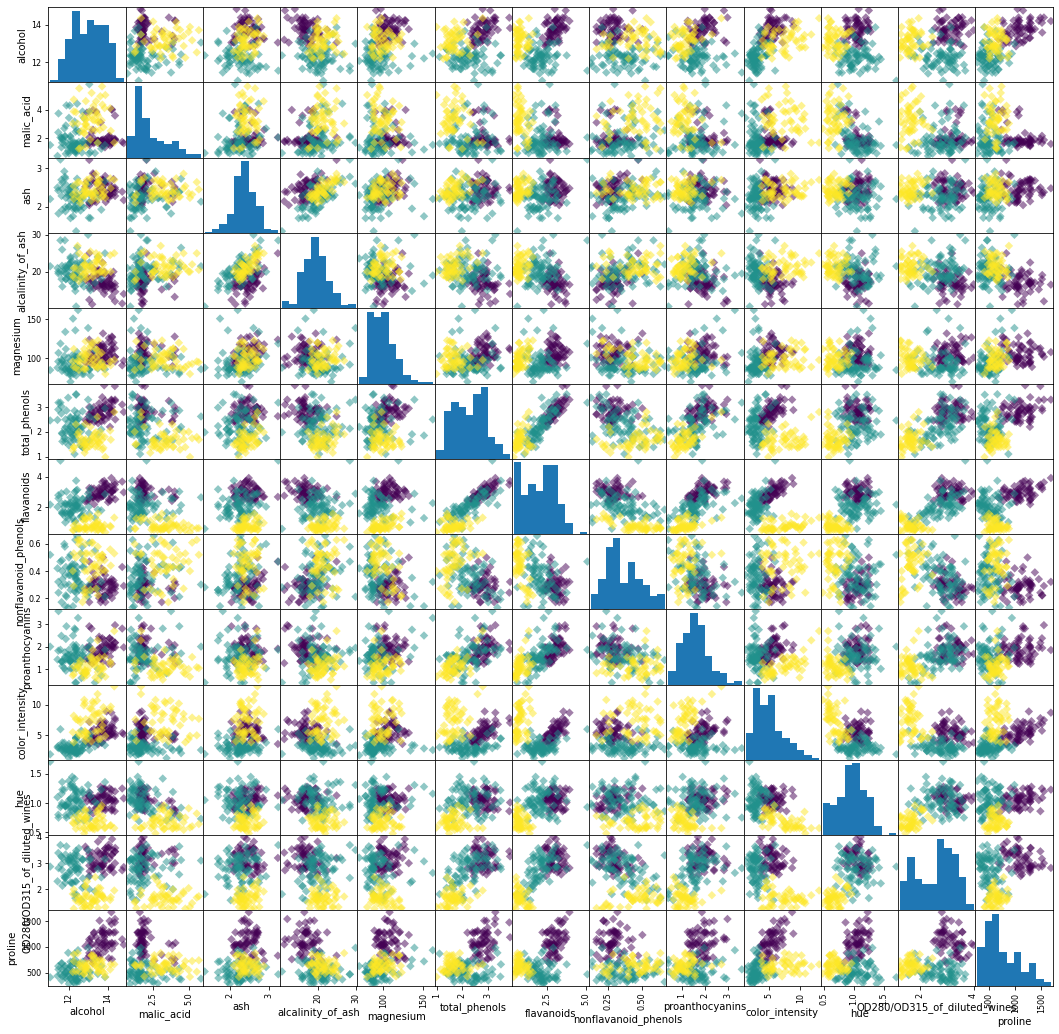

In [66]:
x = wine_pandas.drop(['name'],axis=1)
y = wine_pandas['name']
_ = pd.plotting.scatter_matrix(x, c=y, figsize=[18,18],marker='D')

# Passo 4: Normalizando os dados

In [33]:
def min_max_norm(df, cols):
  for col in cols:
    max_value = df.agg({col:'max'}).collect()[0][0]
    min_value = df.agg({col:'min'}).collect()[0][0]
    new_column = col+'_scaled'
    df = df.withColumn(new_column, (df[col] - min_value) / (max_value - min_value))
  return df

columns_to_scale = ['alcohol','malic_acid','ash','alcalinity_of_ash',
                    'magnesium','total_phenols','flavanoids', 'nonflavanoid_phenols',
                    'proanthocyanins','color_intensity','hue','OD280/OD315_of_diluted_wines', 'proline']
wine_data_escalado = min_max_norm(wine_data, columns_to_scale)
wine_data_escalado.describe().show()

+-------+------------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+--------------------+------------------+-----------------+-------------------+----------------------------+-----------------+-------------------+-------------------+------------------+------------------------+-------------------+--------------------+------------------+---------------------------+----------------------+----------------------+-------------------+-----------------------------------+------------------+
|summary|              name|           alcohol|        malic_acid|               ash|alcalinity_of_ash|         magnesium|     total_phenols|        flavanoids|nonflavanoid_phenols|   proanthocyanins|  color_intensity|                hue|OD280/OD315_of_diluted_wines|          proline|     alcohol_scaled|  malic_acid_scaled|        ash_scaled|alcalinity_of_ash_scaled|   magnesium_scaled|total_phenols_scaled| flavanoids

# Passo 5: Aprendizado de máquina

In [35]:
#preparando os dados
colunas=['alcohol','malic_acid','ash','alcalinity_of_ash',
         'magnesium','total_phenols','flavanoids', 'nonflavanoid_phenols',
         'proanthocyanins','color_intensity','hue','OD280/OD315_of_diluted_wines', 'proline']

vetor = VectorAssembler(inputCols=colunas, outputCol='features')

In [37]:
wine_data_vetor = vetor.transform(wine_data_escalado)
wine_data_vetor.select('features', 'name').show(truncate=False)

+---------------------------------------------------------------------+----+
|features                                                             |name|
+---------------------------------------------------------------------+----+
|[14.23,1.71,2.43,15.6,127.0,2.8,3.06,0.28,2.29,5.64,1.04,3.92,1065.0]|1   |
|[13.2,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.4,1050.0] |1   |
|[13.16,2.36,2.67,18.6,101.0,2.8,3.24,0.3,2.81,5.68,1.03,3.17,1185.0] |1   |
|[14.37,1.95,2.5,16.8,113.0,3.85,3.49,0.24,2.18,7.8,0.86,3.45,1480.0] |1   |
|[13.24,2.59,2.87,21.0,118.0,2.8,2.69,0.39,1.82,4.32,1.04,2.93,735.0] |1   |
|[14.2,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0]|1   |
|[14.39,1.87,2.45,14.6,96.0,2.5,2.52,0.3,1.98,5.25,1.02,3.58,1290.0]  |1   |
|[14.06,2.15,2.61,17.6,121.0,2.6,2.51,0.31,1.25,5.05,1.06,3.58,1295.0]|1   |
|[14.83,1.64,2.17,14.0,97.0,2.8,2.98,0.29,1.98,5.2,1.08,2.85,1045.0]  |1   |
|[13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0]|1   |

## Aplicando os algorítmos de classificação

In [48]:
def executa_classificador(algoritmo, nome):
    vetor = VectorAssembler(inputCols=colunas, outputCol='features')
    pipeline = Pipeline(stages=[vetor, algoritmo])

    train_data, test_data = wine_data.randomSplit([0.7,0.3], seed=42)

    param_grid = ParamGridBuilder() \
                    .addGrid(dt.maxDepth, [5,10, 15]) \
                    .addGrid(dt.maxBins, [8, 16]) \
                    .addGrid(dt.minInstancesPerNode, [1,2]) \
                    .build()

    eval = MulticlassClassificationEvaluator().setLabelCol('name')

    cv = CrossValidator(estimator=pipeline,
                       estimatorParamMaps=param_grid,
                       evaluator=eval,
                       numFolds=5)

    cv_model = cv.fit(train_data)
    cv_model.bestModel.stages[1].extractParamMap()
    print("Acurácia: ",nome, " -> ",eval.evaluate(cv_model.transform(test_data)))

In [60]:
dt = DecisionTreeClassifier(labelCol='name', featuresCol='features')
rf = RandomForestClassifier(labelCol='name', featuresCol='features')

In [49]:
executa_classificador(dt, "DecisionTreeClassifier")

Acurácia:  DecisionTreeClassifier  ->  0.8936170212765957


In [50]:
executa_classificador(rf, "RandomForestClassifier")

Acurácia:  RandomForestClassifier  ->  1.0


## Conclusão:
O algorítmo RandomForest foi o que se saiu melhor na classificação